In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dense,MaxPooling2D,UpSampling2D
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from PIL import Image
import cv2 as cv
import numpy as np
from pathlib import Path
import os
import random
import tqdm

2024-01-24 09:15:56.832471: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 09:15:57.144895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 09:15:57.145017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 09:15:57.186901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 09:15:57.289281: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.config.set_visible_devices([], 'GPU')

2024-01-24 09:16:03.819460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-24 09:16:03.819529: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: aasiku-ideapad
2024-01-24 09:16:03.819538: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: aasiku-ideapad
2024-01-24 09:16:03.819696: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-01-24 09:16:03.819732: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.146.2
2024-01-24 09:16:03.819738: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.146.2 does not match DSO version 535.154.5 -- cannot find working devices in this configuration


In [4]:
cwd = Path.cwd()

In [5]:
list_images = list(cwd.glob("*/*/*/*.jpg"))
len(list_images)

465

In [6]:
for   dirpath, dirnames, filenames in os.walk(Path.joinpath(cwd,'Chessman-image-dataset/Chess')):
    print(f"Inside {Path(dirpath).stem} there are {len(dirnames)} directories and {len(filenames)} files.")

Inside Chess there are 6 directories and 0 files.
Inside Rook there are 0 directories and 102 files.
Inside King there are 0 directories and 76 files.
Inside Queen there are 0 directories and 78 files.
Inside Bishop there are 0 directories and 87 files.
Inside Knight there are 0 directories and 106 files.
Inside Pawn there are 0 directories and 107 files.


In [7]:
Train_images = []
for image_address in list_images:
    Image = cv.imread(str(image_address))
    Image = cv.cvtColor(Image,cv.COLOR_BGR2RGB)
    Image = cv.resize(Image,dsize=(256,256))
    Train_images.append(np.array(Image))


In [8]:
random.shuffle(Train_images)

In [9]:
Train_images[4].shape

(256, 256, 3)

In [10]:
Train_images = np.array(Train_images)


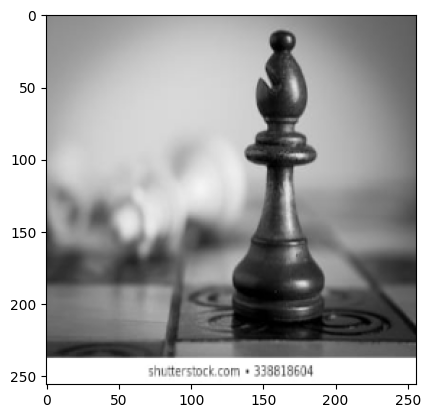

In [11]:
x = random.randint(0,len(Train_images))
plt.imshow(Train_images[x])

In [12]:
# Normalizing the images
Train_images = Train_images/255

In [13]:
# Define the autoencoder model
encode_decode = tf.keras.Sequential([
    Conv2D(32,(3,3),padding = 'same', activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(4,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),

    UpSampling2D((2,2)),
    Conv2D(4,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(3,(3,3),padding = 'same', activation='relu'),
])


In [14]:
encode_decode.compile(optimizer = 'adam',loss= 'mean_squared_error',metrics = ['accuracy'])
encode_decode.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)        0

Loading the saved Weights

In [15]:
encode_decode.load_weights("Saved weights_9.h5")

In [24]:

encode_decode.fit(Train_images,Train_images,epochs=200,batch_size=32)

Epoch 1/200
15/15 [==============================] - 11s 720ms/step - loss: 0.0221 - accuracy: 0.4939
Epoch 2/200
15/15 [==============================] - 11s 699ms/step - loss: 0.0193 - accuracy: 0.5857
Epoch 3/200
15/15 [==============================] - 10s 682ms/step - loss: 0.0182 - accuracy: 0.6501
Epoch 4/200
15/15 [==============================] - 10s 678ms/step - loss: 0.0176 - accuracy: 0.5318
Epoch 5/200
15/15 [==============================] - 10s 680ms/step - loss: 0.0173 - accuracy: 0.6049
Epoch 6/200
15/15 [==============================] - 10s 682ms/step - loss: 0.0172 - accuracy: 0.5961
Epoch 7/200
15/15 [==============================] - 10s 687ms/step - loss: 0.0172 - accuracy: 0.5853
Epoch 8/200
15/15 [==============================] - 10s 693ms/step - loss: 0.0172 - accuracy: 0.5427
Epoch 9/200
15/15 [==============================] - 10s 679ms/step - loss: 0.0172 - accuracy: 0.5715
Epoch 10/200
15/15 [==============================] - 11s 700ms/step - loss: 0.017

Have Trained the model for about 2000 epochs (have only shown the last 200 here),now checking how  it is able to reproduce the real image after the encoding and decoding process

In [63]:
encode_decode.save_weights("Question2_saved_weights.h5")

1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

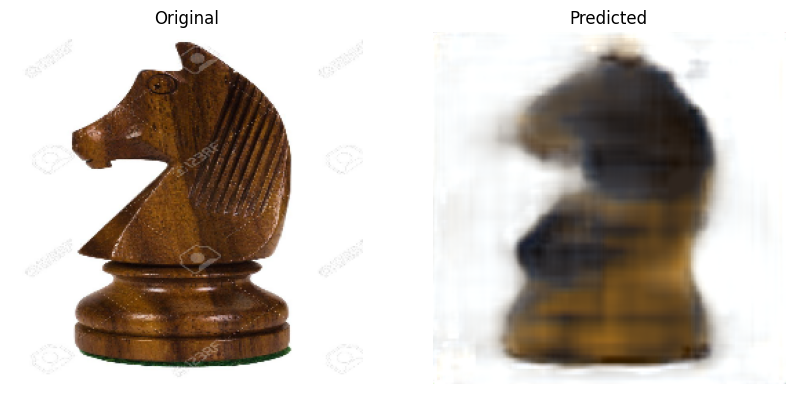

In [94]:
x = random.randint(1,len(Train_images))
image = Train_images[x]
image = image.reshape(1,256,256,3)
image_predicted = encode_decode.predict(image)
image_predicted = image_predicted.squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(Train_images[x])
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_predicted)
plt.title('Predicted')
plt.axis('off')